# Imports

In [84]:
import numpy as np
from scripts.financial_analysis import simulate_revenue

# Player Valuation

This notebook goes over some of the work done in Section 5.2, applying the formula

$$S_{t,t+h} = e^{(\mu - \lambda)h} a_{t+h} R_t\left[\pi^* + (\pi_t - \pi^*) e^{(cv' - \theta)h} + c\sqrt{\pi^*(1-\pi^*) \frac{1-e^{(cv'-\theta)h}}{\theta - cv'}}\right],$$

where

* $t$ is the time of valuation and $t+h$ is when the pay is given;
* $c = \rho \sigma_R \sigma_\pi$
* $v' = \frac{1-2\pi^*}{2\sqrt{\pi^*(1-\pi^*)}}$.

For details on the $(\pi_t)$ process and how $\theta, \pi^*$, and $\sigma_\pi$ are estimated, please see the notebook $\texttt{2\_EPL\_Performance\_Analysis.ipynb}$.  

## Example: Mohamed Salah

## Parameters

We use the estimates given in the paper.  Once these are specified, all subsequent chunks can be run to obtain results.

In [85]:
# Player Specific
pi_star = 0.101
theta = 9.545
sigma_pi = 0.206

# Player Risk Premium
lmda = 0.011

# Revenue Parameters
mu = 0.073
sigma_R = 0.116

# Rho
rho = 0.3

# Team Revenue Specific
# Liverpool Revenue (in million pounds)
R0 = 455.0  # 2018-2019
R1 = 533.0  # 2019-2020
R2 = 490.0  # 2020-2021
R3 = 487.0  # 2021-2022
R4 = 594.0  # 2022-2023

# Player Shares
a1 = 0.219
a2 = 0.233
a3 = 0.255
a4 = 0.208
a5 = 0.239

a = np.array([a1, a2, a3, a4, a5])


# Computed values
c = rho * sigma_R * sigma_pi
v_prime = (1-2*pi_star) / (2*np.sqrt(pi_star*(1-pi_star)))

## $\pi$ Data

In order to apply the formula, we need $\pi_t$ for all times of valuation.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.matrix_utils import compute_q_pi, preprocess_passing_matrix
from scripts.data_processing import process_team_games, rolling_average
from scripts.estimation import pi_mle

pd.set_option('display.float_format', lambda x: '%.4f' % x)



In [87]:
# Define the folders and teams first
folders = ['EPL2018-2019', 'EPL2019-2020', 'EPL2020-2021', 'EPL2021-2022', 'EPL2022-2023']
teams = ['Liverpool']

# Initialize the nested dictionaries correctly
q_df = {team: {} for team in teams}
pi_df = {team: {} for team in teams}

# Process each folder and team
for folder in folders:
    for team in teams:
        print(f"Processing {team} in {folder}")
        q_df[team][folder], pi_df[team][folder] = process_team_games(folder, team, max_games=38)


Processing Liverpool in EPL2018-2019


Processing Liverpool in EPL2019-2020
Processing Liverpool in EPL2020-2021
Processing Liverpool in EPL2021-2022
Processing Liverpool in EPL2022-2023


In [88]:
# Example
team = 'Liverpool'
player_name = 'Mohamed Salah'


# Extract player data across seasons for the specified team and player
player_pis = []
player_dates = []
for folder in folders:
    if player_name in pi_df[team][folder].index:
        player_pis.extend(pi_df[team][folder].loc[player_name])  
        player_dates.extend(pi_df[team][folder].columns)
player_df = pd.DataFrame({'pi_raw': player_pis}, index=pd.to_datetime(player_dates))
player_df


# Convert to numpy array
pi_raw = np.array(player_df['pi_raw'])

pi = rolling_average(pi_raw)

player_df['pi'] = pi

# Add time since start
time_start = player_df.index.min()
player_df['t'] = (player_df.index - time_start).days / 365.25

player_df


,pi_raw,pi,t
2018-08-12,0.0912,0.0990,0.0000
2018-08-20,0.0933,0.0978,0.0219
2018-08-25,0.1193,0.1009,0.0356
2018-09-01,0.0800,0.0975,0.0548
2018-09-15,0.0842,0.0948,0.0931
...,...,...,...
2023-05-03,0.1314,0.1096,4.7228
2023-05-06,0.1544,0.1063,4.7310
2023-05-15,0.0986,0.1088,4.7556
2023-05-20,0.0867,0.1071,4.7693


## Revenue Data

Clubs applying this methodology could use more granular revenue data to perform the valuation.  Otherwise, publicly available is the revenue data accrued for that season, i.e. annually.  To obtain a more realistic outlook for value, we use the given revenue data as the first value for that season, and mid-season data is simulated.  This is done with the $\texttt{simulate\_revenue}$ function.

In [89]:
t = player_df['t'].values
R = np.array([R0, R1, R2, R3, R4])
t_R = np.array([0, 1, 2, 3, 4])

R_sim = simulate_revenue(t, R, t_R, mu, sigma_R, R0, return_mean=False, seed=1, eps=1e-16)


Now, add it to the dataframe.

In [90]:
player_df['R'] = R_sim

Just for fun, we can look at the simulated revenue.

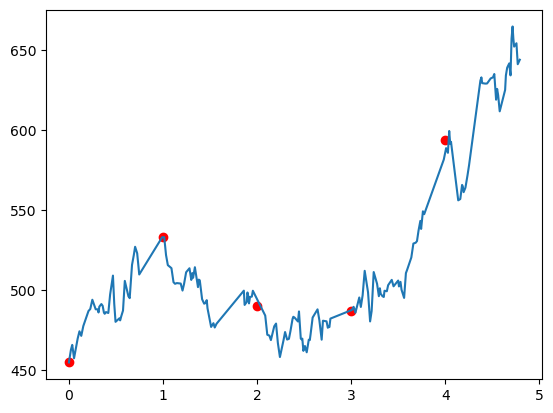

In [91]:
plt.plot(t, R_sim, label='Simulated Revenue')
plt.scatter(t_R, R, color='red', label='Observed Revenue')

Let's consider what the model would pay at the end of the first season.  Assume it is an annual value and the dollar amount would be paid exactly at that time.  First we need the time of payment ($T = t+h$) and the time until payment $(h)$

In [92]:
# first year
player_df_1 = player_df[player_df['t'] < 0.9]  # use 0.9 because the initial t can vary a few days

# payment time
T = player_df_1['t'].max()

# time until payment
player_df_1['h'] = T-player_df_1['t']

/tmp/ipykernel_7283/1079325082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df_1['h'] = T-player_df_1['t']


Now, apply the model

In [93]:
pi = player_df_1['pi']
R = player_df_1['R']
h = player_df_1['h']

player_df_1['S'] = np.exp((mu-lmda)*h) * R * a1 * (
    pi_star +
    (pi - pi_star)*np.exp((c*v_prime-theta)*h) +
    c*np.sqrt(pi_star*(1-pi_star)) * (1 - np.exp((c*v_prime-theta)*h)) / (theta - c*v_prime)
)

/tmp/ipykernel_7283/2339118813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df_1['S'] = np.exp((mu-lmda)*h) * R * a1 * (


In [94]:
player_df_1

,pi_raw,pi,t,R,h,S
2018-08-12,0.0912,0.0990,0.0000,455.0000,0.7474,10.5650
2018-08-20,0.0933,0.0978,0.0219,462.9934,0.7255,10.7358
2018-08-25,0.1193,0.1009,0.0356,465.9772,0.7118,10.7962
2018-09-01,0.0800,0.0975,0.0548,457.6429,0.6927,10.5900
2018-09-15,0.0842,0.0948,0.0931,469.8485,0.6543,10.8458
2018-09-22,0.0947,0.0938,0.1123,474.4553,0.6352,10.9386
2018-09-29,0.0753,0.0911,0.1314,471.6089,0.6160,10.8589
2018-10-07,0.1399,0.0989,0.1533,477.7490,0.5941,10.9875
2018-10-20,0.1735,0.1079,0.1889,483.7145,0.5585,11.1047
2018-10-27,0.1016,0.1115,0.2081,487.0929,0.5394,11.1720


So, for example, the worth projected to the end of the 2018--2019, calculated after the first game was played, is £10.565 million.  *(His actual revenue for that season was £10.4 million.)*

Note that Salah was locked into that contract through the 2021--2022 season, in which case there was a large pay raise to £18.2 million.  For completeness sake, we plot each of the seasons with the pay obtained at the end of the season overlayed.

The next chunk generalizes the work done above to all five seasons considered.

In [95]:
# Define your a and R values in lists for easy access
a_values = [a1, a2, a3, a4, a5]  # a1 corresponds to player_df_1, etc.

# Initialize a dictionary to store the resulting DataFrames
player_dfs = {}

# Loop through each period (1 to 5)
for i in range(1, 6):
    # Define the lower and upper bounds for 't'.  Adjust by 0.1 because sometimes the initial t can vary a few days
    lower_bound = i - 1 + 0.1
    upper_bound = i - 0.1

    # Filter the DataFrame for the current period
    if i == 1:
        # For the first period, t < 1
        df_filtered = player_df[player_df['t'] < upper_bound].copy()
    else:
        # For subsequent periods, lower_bound <= t < upper_bound
        df_filtered = player_df[
            (player_df['t'] >= lower_bound) & (player_df['t'] < upper_bound)
        ].copy()

    # Determine the payment time T as the maximum 't' in the current period
    T = df_filtered['t'].max()

    # Calculate time until payment 'h'
    df_filtered['h'] = T - df_filtered['t']

    # Extract necessary columns
    pi = df_filtered['pi']
    h = df_filtered['h']
    R = df_filtered['R']

    # Retrieve the corresponding a and R values
    a_t = a_values[i - 1]  # a1 for i=1, a2 for i=2, etc.

    # Compute the 'S' column using the provided formula
    df_filtered['S'] = (
        np.exp((mu - lmda) * h) *
        R *
        a_t *
        (
            pi_star +
            (pi - pi_star) * np.exp((c * v_prime - theta) * h) +
            (
                c * np.sqrt(pi_star * (1 - pi_star)) *
                (1 - np.exp((c * v_prime - theta) * h)) /
                (theta - c * v_prime)
            )
        )
    )

    player_dfs[f'player_df_{i}'] = df_filtered



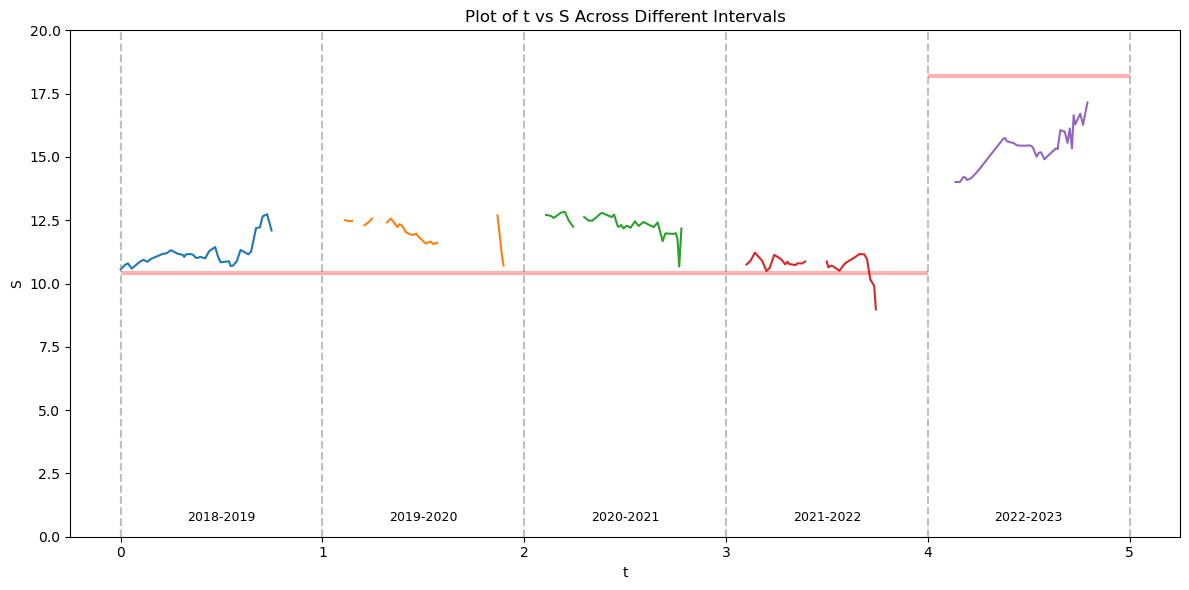

In [96]:
import matplotlib.pyplot as plt

# Define the season labels and corresponding C values
seasons = ["2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023"]
C_values = [10.4, 10.4, 10.4, 10.4, 18.2]

# Create a new figure with desired size
plt.figure(figsize=(12, 6))

# Loop through each player_df and plot 't' vs 'S'
for i in range(1, 6):
    df = player_dfs.get(f'player_df_{i}')
    if df is not None and not df.empty:
        plt.plot(df['t'], df['S'], label=f'Player DF {i}')

# Add vertical dashed lines to separate the intervals
for i in range(6):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

# Add season labels in the middle of each interval
for idx, season in enumerate(seasons):
    mid_point = idx + 0.5  # Middle of the interval [idx, idx+1)
    plt.text(mid_point, 1, season, ha='center', va='top', fontsize=9, rotation=0)

# Overlay the C values as thick, transparent horizontal lines across each interval
for idx, C in enumerate(C_values):
    plt.hlines(y=C, xmin=idx, xmax=idx+1, colors='red', linewidth=3, alpha=0.3)

# Optional: Add a legend if you want to identify each DataFrame
# plt.legend()

# Set labels and title
plt.xlabel('t')
plt.ylabel('S')
plt.ylim(0, 20)
plt.title('Plot of t vs S Across Different Intervals')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


Interestingly, the first few seasons considered suggested Mohamed performing more than his worth.  2021--2022 was spot on with his pay.  The value for 2022--2023 is under the amount paid, but not by a significant amount.  Considering we only have a year of data, it is unclear at this point if the magnitude of the pay raise was warranted.